In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, filtfilt
data_dir = 'DataCollection/outputs/'
ssvep_dir = data_dir + 'SSVEP/'
mi_dir = data_dir + 'MI/'
bci_dir = '../Documents/OpenBCI_GUI/Recordings/OpenBCISession_2023-02-28_12-03-49/'
col_names = ['Fp1', 'O1', 'O2','C3','C4','P3','P4','Pz']

In [19]:
def get_files(file_dir):
    files = []
    for file in sorted(os.listdir(file_dir)):
        files.append(file_dir + file)
    return files

In [20]:
ssvep_files = get_files(ssvep_dir)
mi_files = get_files(mi_dir)
bci_files = get_files(bci_dir)

In [21]:
mi_files

['DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_MILF.txt',
 'DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_MIRF.txt',
 'DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_MISw.txt',
 'DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_MITy.txt',
 'DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_NOMI.txt',
 'DataCollection/outputs/MI/2023-02-28T12:16:33.610938_MI_metadata.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_MILF.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_MIRF.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_MISw.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_MITy.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_NOMI.txt',
 'DataCollection/outputs/MI/2023-02-28T12:49:35.088211_MI_metadata.txt']

In [22]:
def read_openbci_file(file_path):
    """
    Reads an OpenBCI data file and returns a pandas DataFrame containing the EEG data.

    The OpenBCI data file should have the following format:
    - The first four lines should be ignored
    - The fifth line should contain a comma-separated list of electrode names
    - The sixth and onwards lines should contain the EEG data, with each row representing a sample time point
      and each column representing the EEG data from one electrode.

    Args:
        file_path (str): The path and filename of the OpenBCI data file.

    Returns:
        data (pandas.DataFrame): A pandas DataFrame containing the EEG data.
    """
    # Ignore the first four lines and read the fifth line into a list
    with open(file_path, 'r') as f:
        f.readline()
        num_channels = int(f.readline().split('=')[1].strip())
        Fs = f.readline().split('=')[1].strip()
        Fs = int(Fs.split()[0])
        f.readline()
        all_names = f.readline().strip().split(',')
        column_names = all_names[:9] + [all_names[22], all_names[24]]

    # Read the EEG data into a pandas DataFrame
    usecols = [0,1,2,3,4,5,6,7,8,22,24]
    data = pd.read_csv(file_path, header=None, skiprows=5, usecols=usecols, names=column_names)

    return data, num_channels, Fs, column_names

In [23]:
def read_file(file_name, col_names):
    eeg = pd.read_csv(file_name,header=None)
    eeg.columns = col_names
    return eeg
def plot_channel(data, channel):
    chan_data = list(data[channel])
    times = np.arange(len(chan_data))*dt
    plt.plot(times, chan_data)

In [24]:
def get_idx(openbci, names, eeg, col_names):
    val1 = eeg[col_names[0]].iloc[0]
    val2 = eeg[col_names[1]].iloc[0]
    eeg_start = openbci[(abs(openbci[names[1]]-val1) < 0.001) & (abs(openbci[names[2]]-val2) < 0.001)]
    idx = -1
    if len(eeg_start) > 0:
        idx = eeg_start.index[0]
    return idx

In [25]:
def baseline_correct(openbci, names, eeg, col_names, idx):
    baseline_data = openbci.iloc[idx-1000:idx]
    for i,chan in enumerate(col_names):
        bl_mean = bl_data[names[i+1]].mean()
        eeg[chan] = eeg[chan] - bl_mean
    #don't need to return since modified the dataframe

In [26]:
def butter_notch(chan_data, Fs=250, notch_freq=60.0):
    # Define the filter parameters
    Q = 30.0

    # Calculate the notch filter coefficients
    w0 = notch_freq / (Fs / 2)
    b, a = iirnotch(w0, Q)

    # Apply the filter to the EEG data
    notched_data = filtfilt(b, a, chan_data)
    return notched_data

def butter_band(chan_data, Fs=250, low=0.1, high=50):
    # Define the filter parameters
    nyquist_freq = 0.5 * Fs
    lowcut = low / nyquist_freq
    highcut = high / nyquist_freq
    order = 4

    # Create the filter coefficients
    b, a = butter(order, [lowcut, highcut], btype='band')

    # Apply the filter to the EEG data
    filtered_data = filtfilt(b, a, chan_data)
    return filtered_data

def power_spectrum(filtered_data, Fs):
    ft = np.fft.fft(filtered_data)
    freqs = np.fft.fftfreq(n=len(filtered_data), d=1/Fs)
    ps = np.abs(ft)**2
    plt.plot(freqs, ps);
    plt.yscale('log')
    plt.xlim(0,Fs/2)

In [30]:
mi = read_file(mi_files[0], col_names)
bci, num_channels, Fs, column_names = read_openbci_file(bci_files[7])
idx = get_idx(bci, column_names, mi, col_names)
idx

165160

In [31]:
column_names

['Sample Index',
 ' EXG Channel 0',
 ' EXG Channel 1',
 ' EXG Channel 2',
 ' EXG Channel 3',
 ' EXG Channel 4',
 ' EXG Channel 5',
 ' EXG Channel 6',
 ' EXG Channel 7',
 ' Timestamp',
 ' Timestamp (Formatted)']

In [133]:
srate = int(Fs.split()[0])
srate

250

In [87]:
mi = read_file(mi_files[0])
bci, names = read_openbci_file(bci_files[7])
idx = get_idx(bci, names, mi)
mi_bc = baseline_correct(bci, names, mi, idx)

In [105]:
Fs = 250
dt = 1/Fs
times = np.arange(5000)*dt

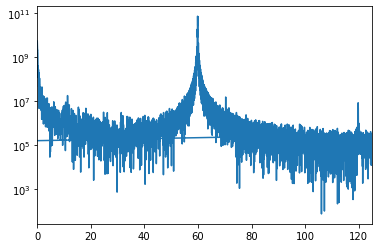

In [121]:
O1_plain = list(mi_bc['O1'])
power_spectrum(O1_plain)
O1_notch = butter_notch(O1_plain)

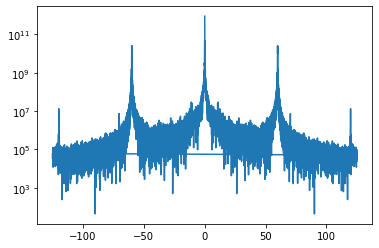

In [39]:
#chan_data = list(df['O1'])
ft = np.fft.fft(mi_df['Fp1'])
freqs = np.fft.fftfreq(n=len(mi_df['Fp1']), d=dt)
ps = np.abs(ft)**2
plt.plot(freqs, ps);
plt.yscale('log')
#plt.xlim(0,Fs/2)

In [10]:
df = pd.read_csv(ssvep_files[0],header=None)
df.columns = col_names

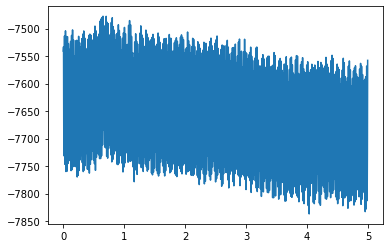

In [20]:
Fs = 250
dt = 1/Fs
times = np.arange(1250)*dt
chan_data = list(df['O1'])
plt.plot(times, chan_data);
#plt.xlim(2,2.25)

In [25]:
# Define the filter parameters
nyquist_freq = 0.5 * Fs
lowcut = 0.1 / nyquist_freq
highcut = 50 / nyquist_freq
order = 4

# Create the filter coefficients
b, a = butter(order, [lowcut, highcut], btype='band')

# Apply the filter to the EEG data
filtered_data = filtfilt(b, a, chan_data)

In [30]:
# Define the filter parameters
notch_freq = 60.0
Q = 30.0

# Calculate the notch filter coefficients
w0 = notch_freq / (Fs / 2)
b, a = iirnotch(w0, Q)

# Apply the filter to the EEG data
notched_data = filtfilt(b, a, chan_data)

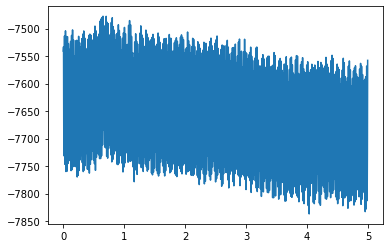

In [26]:
plt.plot(times, chan_data);

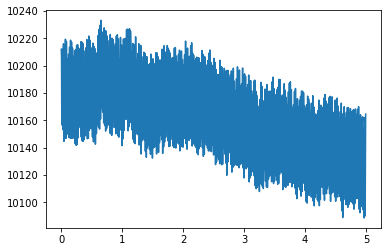

In [8]:
df10 = getFileData(ssvep_files[0])
plotChannel(df10, 'Pz')

(0.0, 125.0)

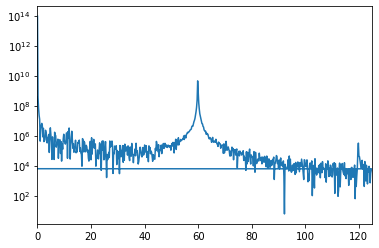

In [37]:
#chan_data = list(df['O1'])
ft = np.fft.fft(chan_data)
freqs = np.fft.fftfreq(n=len(chan_data), d=dt)
ps = np.abs(ft)**2
plt.plot(freqs, ps);
plt.yscale('log')
plt.xlim(0,Fs/2)

(0.0, 125.0)

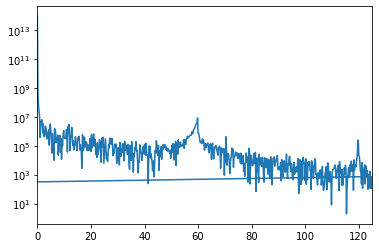

In [38]:
#chan_data = list(df['O1'])
ft = np.fft.fft(notched_data)
freqs = np.fft.fftfreq(n=len(chan_data), d=dt)
ps = np.abs(ft)**2
plt.plot(freqs, ps);
plt.yscale('log')
plt.xlim(0,Fs/2)